# Hello friendly folks at Northwestern! 

This notebok contains a walkthrough to help you get started with TensorFlow. We'll work on a few exercises for...

* Linear Regression, using low-level TensorFlow.  
* Logistic Regression, using low-level TensorFlow.  
* Deep Neural Network, using low-level TensorFlow.
* The above, with Canned Estimators.
* Practical stuff: training models on (possibly large) amounts of structured data.
* Custom Estimators.

Of course, Deep Learning is a wide and rich field, and TensorFlow can do much more than the above. Here are some recent articles you can check out:

* https://research.googleblog.com/2017/06/supercharge-your-computer-vision-models.html
* https://research.googleblog.com/2017/07/building-your-own-neural-machine.html
* https://magenta.tensorflow.org (for many projects using TensorFlow for art & music).

# Installation
Before you begin, please make sure you have TensorFlow version 1.3.0rc0 (or higher) installed on your machine, where *"rc"* means *"release candidate"*. We'll be working with the Datasets API, which we're currently developing to make it easy to efficiently train models on large amounts of data (say, that are too big to fit into memory).


# Learning more

Here are some short videos and a couple book recommendations.

* Machine Learning Recipes: https://goo.gl/uRR7r4
* Hands-On Machine Learning with Scikit-Learn and TensorFlow: http://shop.oreilly.com/product/0636920052289.do
* Deep Learning with Python: https://www.manning.com/books/deep-learning-with-python

You can follow TensorFlow on Twitter, if you like, at https://twitter.com/tensorflow

## Imports
If you can successfully run this cell, then your machine is properly configured for this tutorial. If the only line that's causing you problems is *import pylab* and the next, you can safely comment those out and skip the cells that use them later.

In [1]:
# Python 2 & 3 compatibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import os

import numpy as np
import pandas as pd

import pylab
%matplotlib inline

import tensorflow as tf
print('You are running TensorFlow version:', tf.__version__)

from tensorflow.examples.tutorials.mnist import input_data

You are running TensorFlow version: 1.2.1


# 1) Linear Regression (with low-level code)

Let's start our journey by taking a look at lower-level TensorFlow code, to get a sense for how things work under the hood. Fear not, intrepid reader - you need not write graph-level code in practice unless you'd like to.

### Let's generate some data

This function will create a noisy dataset that's roughly linear, according to the equation *y = mx + b + noise*. As you might expect, we'll then try to find the best fit line. Of course, there's a closed form solution to this - but we'll use gradient descent as an exercise.

In [2]:
def make_noisy_data(m=0.1, b=0.3, n=100):
    x = np.random.rand(n).astype(np.float32)
    noise = np.random.normal(scale=0.01, size=len(x))
    y = m * x + b + noise
    return x, y

Create training and testing data.

In [3]:
x_train, y_train = make_noisy_data()
x_test, y_test = make_noisy_data()

In [4]:
# Uncomment the following lines to plot the data.
# Isn't it beautiful?
# Training data is shown in blue, and testing data in green.
# pylab.plot(x_train, y_train, 'b.')
# pylab.plot(x_test, y_test, 'g.')

### Prepare the graph

In [5]:
# The following line (as you might imagine) clears the graph.
# Why do we need it? Jupyter Notebooks maintain state.
# If you run this Notebook twice (and forget to reset it), 
# this line will restore everything to a clean state for you.
tf.reset_default_graph()

In [6]:
# You can think of a Session as an 'execution environment' for a graph.
# We won't need this until we're ready to run the graph, but
# I'll create it now, just for kicks.
sess = tf.Session()

In [7]:
# Path to a log directory.
# As written, it will be created in the same directory as this notebook.
# Later, we'll use TensorBoard to visualize data stored 
# in this directory - and it will be awesome.

# Tip:
# If you have trouble with TensorBoard, delete
# the log directory, and re-run the notebook.
LOGDIR = './graphs'

Define placeholders for data we'll feed to the graph.

In [8]:
# You can think of a 'Placeholder' as a promise. It's a value we 
# promise to provide when we execute the graph.
# A lot of this code is for display purposes.
# - 'tf.name_scope' nests our placeholders under an 'input' block
# - name='x-input' gives TensorBoard a display name for this node.
# shape=[None] means x_placeholder is a one dimensional array of any length. 
# - this is so we can feed a 'batch' of data later, for example,
# - for stochastic gradient descent, or to make predictions.
with tf.name_scope('input'):
    x_placeholder = tf.placeholder(shape=[None], dtype=tf.float32, name='x-input')
    y_placeholder = tf.placeholder(shape=[None], dtype=tf.float32, name='y-input')

### Define our model.

Here, we'll use a linear model (e.g., *y = mx + b*)

In [9]:
with tf.name_scope('model'):
    m = tf.Variable(tf.random_normal([1]), name='m')
    b = tf.Variable(tf.random_normal([1]), name='b')
    # This is the same as y = tf.add(tf.mul(m, x_placeholder), b), 
    # but looks nicer
    y = m * x_placeholder + b

### The Loss and Optimizer

Define a loss function (*mean squared error*) and an optimizer (*vanilla gradient descent*).

In [10]:
LEARNING_RATE = 0.5 # a magic number!
# as you gain experience with Deep Learning,
# you will become proficient in picking proper
# values (or just stop worrying about it)

with tf.name_scope('training'):
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.square(y - y_placeholder))
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
        train = optimizer.minimize(loss) 

### Log values in TensorBoard
Later, we'll get this for free.

In [11]:
# Write the graph
writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)

# Attach summaries to Tensors (for TensorBoard visualization)
tf.summary.histogram('m', m)
tf.summary.histogram('b', b)
tf.summary.scalar('loss', loss)

# This op will calculate our summary data when run
summary_op = tf.summary.merge_all()

### Initialize variables
At this point, our graph is complete - and we're nearly ready to begin training. First, variables must be initialized. Don't forget this line - the fate of the universe is uncertain, if you do.

In [12]:
# Notice we're running this line with our session.
# All the TensorFlow code prior to this point has
# served to define the graph.
sess.run(tf.global_variables_initializer())

In [13]:
# 'm' and 'b' were initialized to random values
# let's see what these were
initial_vals = sess.run([m, b])
print ("Initial values for m: %f, b: %f" % (initial_vals[0], initial_vals[1]))

Initial values for m: 1.025586, b: -0.626024


### Train
Here, we'll iteratively update the values for 'm' and 'b' using gradient descent

In [14]:
TRAIN_STEPS = 201

for step in range(TRAIN_STEPS):
        
    # Session will run two ops:
    # - summary_op prepares summary data we'll write to disk in a moment
    # - train will use the optimizer to adjust our variables to reduce loss
    summary_result, _ = sess.run([summary_op, train], 
                                  feed_dict={x_placeholder: x_train, 
                                             y_placeholder: y_train})
    # write the summary data to disk
    writer.add_summary(summary_result, step)
    
    # Uncomment the following two lines to watch training happen real time.
    if step % 20 == 0:
        vals = sess.run([m, b])
        print("Step: %d, m: %f, b: %f" % (step, vals[0], vals[1]))
    
# close the writer when we're finished using it
writer.close()

Step: 0, m: 1.175373, b: -0.166666
Step: 20, m: 0.344110, b: 0.167180
Step: 40, m: 0.156737, b: 0.268489
Step: 60, m: 0.111893, b: 0.292735
Step: 80, m: 0.101160, b: 0.298538
Step: 100, m: 0.098592, b: 0.299927
Step: 120, m: 0.097977, b: 0.300259
Step: 140, m: 0.097830, b: 0.300339
Step: 160, m: 0.097795, b: 0.300358
Step: 180, m: 0.097786, b: 0.300362
Step: 200, m: 0.097784, b: 0.300364


### See the learned values for 'm' and 'b'

In [15]:
# If things worked properly, 'm' should be about 0.1, 
# and 'b' should be about 0.3
# (+/- a bit, because we added noise when we generated the data)
print ("Learned values for m: %f, b: %f" % (sess.run(m), sess.run(b)))

Learned values for m: 0.097784, b: 0.300364


### Use the trained model to make a prediction

In [16]:
# Use the trained model to make a prediction!
# Remember that x_placeholder must be a vector, hence [2] not just 2.
# We expect the result to be (about): 2 * 0.1 + 0.3 + noise ~= 0.5
sess.run(y, feed_dict={x_placeholder: [2]})

array([ 0.49593186], dtype=float32)

### Start TensorBoard

Let's see what we got for all that work logging variables.

Start TensorBoard by running this command from a terminal.

```$ tensorboard --logdir=graphs```

Note: first ```cd``` into the directory that contains this notebook. If you are running TensorFlow in a *virtualenv* and you have opened a new terminal window, be sure to start the *virtualenv* again before running TensorBoard.

After you have run this command, open TensorBoard by pointing your browser to *http://localhost:6006* Then, click on the tabs for 'scalars', 'distributions', 'histograms', and 'graphs' to learn more.

If you run into trouble, delete LOGDIR (to clear information from previous runs), then re-run this script, and restart TensorBoard.

# Logistic Regression, using low-level code

We will now use a linear model to classify handwritten digits from the MNIST dataset.

In [17]:
tf.reset_default_graph()
sess = tf.Session()

In [18]:
# Import the MNIST dataset. 
# It will be downloaded to '/tmp/data' if you don't already have a local copy.
mnist = input_data.read_data_sets('/tmp/data', one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [19]:
# Uncomment these lines to understand the format of the dataset.

# 1. There are 55k, 5k, and 10k examples in train, validation, and test.
# print ('Train, validation, test: %d, %d, %d' % 
#       (len(mnist.train.images), len(mnist.validation.images), len(mnist.test.images)))

# 2. The format of the labels is 'one-hot'.
# The fifth image happens to be a '6'.
# This is represented as '[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]'
# print (mnist.train.labels[4])

# You can find the index of the label, like this:
# print (np.argmax(mnist.train.labels[4]))

# 3. An image is a 'flattened' array of 28*28 = 784 pixels.
# print (len(mnist.train.images[4]))

# 4. To display an image, first reshape it to 28x28.
# pylab.imshow(mnist.train.images[4].reshape((28,28)), cmap=pylab.cm.gray_r)   
# pylab.title('Label: %d' % np.argmax(mnist.train.labels[4])) 

In [20]:
NUM_CLASSES = 10
NUM_PIXELS = 28 * 28
TRAIN_STEPS = 2000
BATCH_SIZE = 100
LEARNING_RATE = 0.5

In [21]:
# Define inputs
images = tf.placeholder(dtype=tf.float32, shape=[None, NUM_PIXELS])
labels = tf.placeholder(dtype=tf.float32, shape=[None, NUM_CLASSES])

In [22]:
# Define model
W = tf.Variable(tf.truncated_normal([NUM_PIXELS, NUM_CLASSES]))
b = tf.Variable(tf.zeros([NUM_CLASSES]))
y = tf.matmul(images, W) + b

In [23]:
# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=labels))
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss) 

In [24]:
# Initialize variables after the model is defined
sess.run(tf.global_variables_initializer())

In [25]:
# Train the model
for i in range(TRAIN_STEPS):
    batch_images, batch_labels = mnist.train.next_batch(BATCH_SIZE)
    sess.run(train_step, feed_dict={images: batch_images, labels: batch_labels})

In [26]:
# Evaluate the trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                                  
print("Accuracy %f" % sess.run(accuracy, feed_dict={images: mnist.test.images, 
                                                    labels: mnist.test.labels}))

Accuracy 0.894400


A method to make predictions on a single image

Predicted: 1, actual: 1


(array([1]), 1)

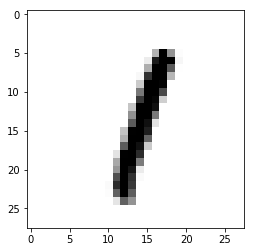

In [27]:
def predict(i):
    image = mnist.test.images[i]
    actual_label = np.argmax(mnist.test.labels[i])
    prediction = tf.argmax(y,1)
    predicted_label = sess.run(prediction, feed_dict={images: [image]})
    print ("Predicted: %d, actual: %d" % (predicted_label, actual_label))
    pylab.imshow(mnist.test.images[i].reshape((28,28)), cmap=pylab.cm.gray_r) 
    return predicted_label, actual_label

predict(5)

# 3) A Deep Neural Network, using low-level TensorFlow code.

Using the magic of automatic differentiation, we will now write a Deep Neural Network to classify handwritten digits. If this seems like a big jump from Linear and Logistic Regression - keep in mind, the goal of this exercise is to show you that the part of the code that does the *"hard work"* (training the model) is nearly identical. We need only change the code to specify the model (a stack of fully connected layers instead of y = Wx + b). Once that's done, we can train the DNN using TensorFlow in the *same* way we train the Linear / Logistic models.

In [28]:
tf.reset_default_graph()
sess = tf.Session()

In [29]:
# number of neurons in each hidden layer
HIDDEN1_SIZE = 500
HIDDEN2_SIZE = 250

NUM_CLASSES = 10
NUM_PIXELS = 28 * 28

# experiment with the nubmer of training steps to 
# see the effect
TRAIN_STEPS = 2000
BATCH_SIZE = 100

# we're using a different learning rate than the previous
# notebook, and a new optimizer
LEARNING_RATE = 0.001

In [30]:
# Define inputs
with tf.name_scope('input'):
    images = tf.placeholder(tf.float32, [None, NUM_PIXELS], name="pixels")
    labels = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="labels")

In [31]:
# Method to create a fully connected layer
def fc_layer(input, size_out, name="fc", activation=None):
    with tf.name_scope(name):
        size_in = int(input.shape[1])
        w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="bias")
        wx_plus_b = tf.matmul(input, w) + b
        if activation: return activation(wx_plus_b)
        return wx_plus_b
    
# The way we initialize variables has an affect on how quickly 
# training converges. We may explore with different strategies later.
# w = tf.Variable(tf.truncated_normal(shape=[size_in, size_out], stddev=1.0 / math.sqrt(float(size_in))))

In [32]:
# Define the model

# First, we'll create two fully connected layers, with ReLU activations
fc1 = fc_layer(images, HIDDEN1_SIZE, "fc1", activation=tf.nn.relu)
fc2 = fc_layer(fc1, HIDDEN2_SIZE, "fc2", activation=tf.nn.relu)

# Next, we'll apply Dropout to the second layer
# This can help prevent overfitting, and I've added it here
# for illustration. You can comment this out, if you like.
dropped = tf.nn.dropout(fc2, keep_prob=0.9)

# Finally, we'll calculate logists. This will be
# the input to our Softmax function. Notice we 
# don't apply an activation at this layer.
# If you've commented out the dropout layer,
# switch the input here to 'fc2'.
y = fc_layer(dropped, NUM_CLASSES, name="output")

In [33]:
# Define loss and an optimizer
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=labels))
    tf.summary.scalar('loss', loss)

with tf.name_scope("optimizer"):
    # Whereas in the previous notebook we used a vanilla GradientDescentOptimizer
    # here, we're using Adam. This is a single line of code change, and more
    # importantly, TensorFlow will still automatically analyze our graph
    # and determine how to adjust the variables to decrease the loss.
    train = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

In [34]:
# Define evaluation
with tf.name_scope("evaluation"):
    # these there lines are identical to the previous notebook.
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)    

In [35]:
# Set up logging.
# We'll use a second FileWriter to summarize accuracy on
# the test set. This will let us display it nicely in TensorBoard.
train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, "train"))
train_writer.add_graph(sess.graph)
test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, "test"))
summary_op = tf.summary.merge_all()

In [36]:
sess.run(tf.global_variables_initializer())

In [37]:
for step in range(TRAIN_STEPS):
    batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
    summary_result, _ = sess.run([summary_op, train], 
                                    feed_dict={images: batch_xs, labels: batch_ys})

    train_writer.add_summary(summary_result, step)
    train_writer.add_run_metadata(tf.RunMetadata(), 'step%03d' % step)
    
    # calculate accuracy on the test set, every 100 steps.
    # we're using the entire test set here, so this will be a bit slow
    if step % 100 == 0:
        summary_result, acc = sess.run([summary_op, accuracy], 
                                       feed_dict={images: mnist.test.images, 
                                                  labels: mnist.test.labels})
        test_writer.add_summary(summary_result, step)
        test_writer.add_run_metadata(tf.RunMetadata(), 'step%03d' % step)
        print ("test accuracy: %f at step %d" % (acc, step))


print("Accuracy %f" % sess.run(accuracy, 
                               feed_dict={images: mnist.test.images,
                                          labels: mnist.test.labels}))
train_writer.close()
test_writer.close()

test accuracy: 0.195400 at step 0
test accuracy: 0.921200 at step 100
test accuracy: 0.935100 at step 200
test accuracy: 0.952700 at step 300
test accuracy: 0.954200 at step 400
test accuracy: 0.955100 at step 500
test accuracy: 0.966300 at step 600
test accuracy: 0.967200 at step 700
test accuracy: 0.969800 at step 800
test accuracy: 0.968000 at step 900
test accuracy: 0.969900 at step 1000
test accuracy: 0.971600 at step 1100
test accuracy: 0.968600 at step 1200
test accuracy: 0.974100 at step 1300
test accuracy: 0.970700 at step 1400
test accuracy: 0.973900 at step 1500
test accuracy: 0.975100 at step 1600
test accuracy: 0.976300 at step 1700
test accuracy: 0.975200 at step 1800
test accuracy: 0.977100 at step 1900
Accuracy 0.976900


# 4) Linear Regression with a Canned Estimator  

Now let's begin working with higher-level code. We will again train a linear regression model, in just a few lines.

### Input Pipeline

In [38]:
x_dict = {'x': x_train}
train_input = tf.estimator.inputs.numpy_input_fn(x_dict, y_train,
                                                 shuffle=True,
                                                 num_epochs=None) # repeat forever

### Describe input feature usage

In [39]:
features = [tf.feature_column.numeric_column('x')]

### Build and train the model
After you run this next block, you should see an output line in the logs resembling:

```WARNING:tensorflow:Using temporary folder as model directory: /var/folders/sf/j86k2fg96m96w2hmwlsdrvr8006h_5/T/tmpSkPFHV```

You can then start TensorBoard, pointing to that directory like this:

```$ tensorboard --logdir=/var/folders/sf/j86k2fg96m96w2hmwlsdrvr8006h_5/T/tmpSkPFHV```

In [40]:
estimator = tf.estimator.LinearRegressor(features)
estimator.train(train_input, steps=1000)

AttributeError: 'module' object has no attribute 'LinearRegressor'

### Predict

In [41]:
data_source = tf.estimator.inputs.numpy_input_fn({'x': x_test}, shuffle=False)

predictions = list(estimator.predict(data_source))
preds = [p['predictions'][0] for p in predictions]

#for y in predictions:
#    print(y['predictions'])
#predictions

NameError: name 'estimator' is not defined

NameError: name 'preds' is not defined

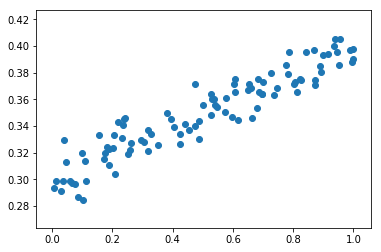

In [42]:
pylab.scatter(x_train, y_train)
pylab.plot(x_test, np.array(preds), 'g')

Hopefully, this felt easier that the lower-level code above.

# 5) Training Models on (possibly large amounts) of Structured Data

### Download the dataset

Here, we'll work with the "Adult dataset" from the U.S. Census bureau. Our task will be to predict whether an individual makes more than $50,000 a year based attributes such as education, hours of work per week, etc. More about this dataset is [here](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/old.adult.names).

### You can adapt this code for a problem you care about

Our goal here is to demonstrate how to work with data you might represent in a CSV file. Hopefully, you can adapt this code to a problem you care about. 

### What if I have *lots* of data?

The code presented here can be adapted to any CSV dataset that fits in memory (using the *pandas input function*) or a dataset of pretty much any size (using the *Datasets API*, below) - which contains logic to efficiently read it from disk. When you're training large models using GPUs, you want to be sure your input pipeline doesn't bottleneck (or starve) the GPU. The Datasets API handle this for you.

In [ ]:
census_train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
census_train_path = tf.contrib.keras.utils.get_file('census.train', census_train_url)

census_test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
census_test_path = tf.contrib.keras.utils.get_file('census.test', census_test_url)

### Load the data

In [ ]:
column_names = [
  'age', 'workclass', 'fnlwgt', 'education', 'education-num',
  'marital-status', 'occupation', 'relationship', 'race', 'sex',
  'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
  'income'
]

census_train = pd.read_csv(census_train_path, index_col=False, names=column_names) 
census_test = pd.read_csv(census_train_path, index_col=False, names=column_names) 

census_train_label = census_train.pop('income') == " >50K" 
census_test_label = census_test.pop('income') == " >50K"

In [ ]:
census_train.head(10)

In [ ]:
census_train_label[:20]

### Input pipeline

In [ ]:
train_input = tf.estimator.inputs.pandas_input_fn(
    census_train, 
    census_train_label,
    shuffle=True, 
    batch_size = 32, # process 32 examples at a time
    num_epochs=None,
)

In [ ]:
test_input = tf.estimator.inputs.pandas_input_fn(
    census_test, 
    census_test_label, 
    shuffle=True, 
    num_epochs=1)

In [ ]:
features, labels = train_input()
features

### Feature description

In [ ]:
features = [
    tf.feature_column.numeric_column('hours-per-week'),
    tf.feature_column.bucketized_column(tf.feature_column.numeric_column('education-num'), list(range(25))),
    tf.feature_column.categorical_column_with_vocabulary_list('sex', ['male','female']),
    tf.feature_column.categorical_column_with_hash_bucket('native-country', 1000),
]

In [ ]:
estimator = tf.estimator.LinearClassifier(features, model_dir='census/linear',n_classes=2)

In [ ]:
estimator.train(train_input, steps=5000)

### Evaluate the model

In [ ]:
estimator.evaluate(test_input)

In [ ]:
predictions = [p for p in estimator.predict(test_input)]
print (predictions[0]["probabilities"])

## DNN model

### Update input pre-processing

In [ ]:
features = [
    tf.feature_column.numeric_column('education-num'),
    tf.feature_column.numeric_column('hours-per-week'),
    tf.feature_column.numeric_column('age'),
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list('sex',['male','female'])),
    tf.feature_column.embedding_column(  # now using embedding!
        tf.feature_column.categorical_column_with_hash_bucket('native-country', 1000), 10)
]

In [ ]:
estimator = tf.estimator.DNNClassifier(hidden_units=[20,20], 
                                       feature_columns=features, 
                                       n_classes=2, 
                                       model_dir='census/dnn')

In [ ]:
estimator.train(train_input, steps=5000)

In [ ]:
estimator.evaluate(test_input)

## Custom Input Pipeline using Datasets API

### Read the data

In [ ]:
def census_input_fn(path):
    def input_fn():    
        dataset = (
            tf.contrib.data.TextLineDataset(path)
                .map(csv_decoder)
                .shuffle(buffer_size=100)
                .batch(32)
                .repeat())

        columns = dataset.make_one_shot_iterator().get_next()
        income = tf.equal(columns.pop('income')," >50K") 
        return columns, income
    return input_fn

In [ ]:
csv_defaults = collections.OrderedDict([
  ('age',[0]),
  ('workclass',['']),
  ('fnlwgt',[0]),
  ('education',['']),
  ('education-num',[0]),
  ('marital-status',['']),
  ('occupation',['']),
  ('relationship',['']),
  ('race',['']),
  ('sex',['']),
  ('capital-gain',[0]),
  ('capital-loss',[0]),
  ('hours-per-week',[0]),
  ('native-country',['']),
  ('income',['']),
])

In [ ]:
def csv_decoder(line):
  parsed = tf.decode_csv(line, csv_defaults.values())
  return dict(zip(csv_defaults.keys(), parsed))

### Try the input function

In [ ]:
tf.reset_default_graph()
census_input = census_input_fn(census_train_path)
training_batch = census_input()

In [ ]:
with tf.Session() as sess:
    features, high_income = sess.run(training_batch)

In [ ]:
print(features['education'])

In [ ]:
print(features['age'])

In [ ]:
print(high_income)

## 6) A Custom Estimator for a CNN

In [43]:
train,test = tf.contrib.keras.datasets.mnist.load_data()
x_train,y_train = train 
x_test,y_test = test

mnist_train_input = tf.estimator.inputs.numpy_input_fn({'x':np.array(x_train, dtype=np.float32)},
                                                       np.array(y_train,dtype=np.int32),
                                                       shuffle=True,
                                                       num_epochs=None)

mnist_test_input = tf.estimator.inputs.numpy_input_fn({'x':np.array(x_test, dtype=np.float32)},
                                                      np.array(y_test,dtype=np.int32),
                                                      shuffle=True,
                                                      num_epochs=1)


### tf.estimator.LinearClassifier

In [44]:
estimator = tf.estimator.LinearClassifier([tf.feature_column.numeric_column('x',shape=784)], 
                                          n_classes=10,
                                          model_dir="mnist/linear")
estimator.train(mnist_train_input, steps = 10000)

AttributeError: 'module' object has no attribute 'LinearClassifier'

In [45]:
estimator.evaluate(mnist_test_input)

NameError: name 'estimator' is not defined

### Examine the results with [TensorBoard](http://0.0.0.0:6006)
$> tensorboard --logdir mnnist/DNN

In [46]:
estimator = tf.estimator.DNNClassifier(hidden_units=[256],
                                       feature_columns=[tf.feature_column.numeric_column('x',shape=784)], 
                                       n_classes=10,
                                       model_dir="mnist/DNN")
estimator.train(mnist_train_input, steps = 10000)

AttributeError: 'module' object has no attribute 'DNNClassifier'

In [47]:
estimator.evaluate(mnist_test_input)

NameError: name 'estimator' is not defined

In [48]:
# Parameters
BATCH_SIZE = 128
STEPS = 10000

## A Custom Model

In [49]:
def build_cnn(input_layer, mode):
    with tf.name_scope("conv1"):  
      conv1 = tf.layers.conv2d(inputs=input_layer,filters=32, kernel_size=[5, 5],
                               padding='same', activation=tf.nn.relu)

    with tf.name_scope("pool1"):  
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    with tf.name_scope("conv2"):  
      conv2 = tf.layers.conv2d(inputs=pool1,filters=64, kernel_size=[5, 5],
                               padding='same', activation=tf.nn.relu)

    with tf.name_scope("pool2"):  
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    with tf.name_scope("dense"):  
      pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
      dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    with tf.name_scope("dropout"):  
      is_training_mode = mode == tf.estimator.ModeKeys.TRAIN
      dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=is_training_mode)

    logits = tf.layers.dense(inputs=dropout, units=10)

    return logits


In [53]:
def model_fn(features, labels, mode):
  # Describing the model
  input_layer = tf.reshape(features['x'], [-1, 28, 28, 1])
    
  tf.summary.image('mnist_input',input_layer)
    
  logits = build_cnn(input_layer, mode)
 
  # Generate Predictions
  classes = tf.argmax(input=logits, axis=1)
  predictions = {
      'classes': classes,
      'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    # Return an EstimatorSpec object
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  with tf.name_scope('loss'):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
  
  loss = tf.reduce_sum(loss)
  tf.summary.scalar('loss', loss)
    
  with tf.name_scope('accuracy'):
    accuracy = tf.cast(tf.equal(tf.cast(classes,tf.int32),labels),tf.float32)
  accuracy = tf.reduce_mean(accuracy)
  tf.summary.scalar('accuracy', accuracy)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.train.get_global_step(),
        learning_rate=1e-4,
        optimizer='Adam')

    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                      loss=loss, train_op=train_op)

  # Configure the accuracy metric for evaluation
  eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(
          classes,
          labels)
  }

  return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                    loss=loss, eval_metric_ops=eval_metric_ops)


## Run config

In [57]:
# create estimator
run_config = tf.contrib.learn.RunConfig(model_dir='mnist/CNN')
estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config)

# train for 1000 steps
# this is too few
#estimator.train(input_fn=mnist_train_input, steps=100)

# evaluate
evaluation = estimator.evaluate(input_fn=mnist_test_input)
print(evaluation)
# predict
preds = estimator.predict(input_fn=mnist_test_input)
#for p in preds:
#    print(p)

INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_task_type': None, '_master': '', '_session_config': None, '_save_checkpoints_secs': 600, '_environment': 'local', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6c191a6f28>, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_id': 0, '_save_checkpoints_steps': None, '_num_worker_replicas': 0, '_model_dir': 'mnist/CNN', '_is_chief': True, '_evaluation_master': '', '_num_ps_replicas': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
}
INFO:tensorflow:Starting evaluation at 2017-08-04-22:13:38
INFO:tensorflow:Restoring parameters from mnist/CNN/model.ckpt-101
INFO:tensorflow:Finished evaluation at 2017-08-04-22:13:43
INFO:tensorflow:Saving dict for global step 101: accuracy = 0.9362, global_step = 101, loss = 40.0468
{'accuracy': 0.93620002, 'loss': 40.046825, 'global_step': 101}
INFO:tensorflow:Restoring parameters from mni

{'classes': 5, 'probabilities': array([  2.73572711e-15,   7.49170367e-18,   7.78359185e-21,
         3.20683095e-15,   9.52245689e-18,   1.00000000e+00,
         5.05290101e-19,   2.73056973e-20,   5.58840405e-11,
         1.26657823e-18], dtype=float32)}
{'classes': 4, 'probabilities': array([  1.27224064e-06,   2.80083877e-05,   1.45697399e-04,
         3.66822064e-07,   9.88456130e-01,   1.21546847e-07,
         8.68727057e-07,   1.61405251e-06,   2.47680447e-07,
         1.13656186e-02], dtype=float32)}
{'classes': 9, 'probabilities': array([  4.45360977e-16,   4.24280582e-19,   3.39204073e-19,
         2.64558307e-14,   4.25493842e-11,   4.16938009e-14,
         2.38724755e-17,   1.82438498e-06,   4.13636817e-13,
         9.99998212e-01], dtype=float32)}
{'classes': 0, 'probabilities': array([  1.00000000e+00,   4.95152730e-17,   3.99408284e-10,
         1.01383637e-13,   3.80391909e-17,   2.56120680e-09,
         3.76349613e-14,   3.03835317e-17,   6.13556872e-10,
         1.185

{'classes': 0, 'probabilities': array([  6.74013972e-01,   1.28236809e-12,   2.06811235e-09,
         4.62541298e-04,   8.97934017e-13,   3.69188463e-04,
         1.52490477e-12,   1.49078829e-12,   3.25124085e-01,
         3.02841781e-05], dtype=float32)}
{'classes': 6, 'probabilities': array([  8.67692793e-11,   6.83179784e-17,   7.99684763e-09,
         2.07707335e-17,   4.02699368e-16,   1.80853122e-13,
         1.00000000e+00,   2.67083549e-15,   8.24211711e-14,
         3.77302303e-16], dtype=float32)}
{'classes': 9, 'probabilities': array([  1.52913726e-09,   4.88396346e-12,   2.92683580e-06,
         1.26485787e-07,   4.17454848e-10,   2.93277736e-07,
         5.32453459e-09,   1.78807184e-07,   4.85243022e-01,
         5.14753401e-01], dtype=float32)}
{'classes': 0, 'probabilities': array([  6.67859018e-01,   1.23581171e-11,   5.41729682e-11,
         1.88737406e-14,   1.44892293e-10,   1.91020265e-01,
         9.13725898e-07,   2.81756828e-15,   1.41119629e-01,
         1.929

{'classes': 8, 'probabilities': array([  1.74868764e-09,   8.36025433e-12,   7.95990309e-06,
         8.50513875e-02,   5.80479975e-09,   4.84276476e-04,
         1.77700465e-13,   5.93834443e-07,   9.14455771e-01,
         1.40299972e-09], dtype=float32)}
{'classes': 0, 'probabilities': array([  1.00000000e+00,   4.55385633e-18,   8.84739764e-13,
         1.69099678e-15,   2.73084193e-19,   1.65755104e-10,
         7.17768731e-16,   1.87779971e-14,   1.13919079e-14,
         2.00973305e-15], dtype=float32)}
{'classes': 8, 'probabilities': array([  1.13827153e-03,   1.80961406e-13,   3.51368212e-10,
         7.91830814e-07,   9.03879077e-13,   9.26764333e-05,
         2.17995413e-12,   5.78352064e-14,   9.98768270e-01,
         5.52876323e-08], dtype=float32)}
{'classes': 4, 'probabilities': array([  2.43414865e-15,   1.69284326e-11,   3.59066631e-11,
         7.88507870e-11,   9.99083161e-01,   3.22221666e-10,
         1.73585590e-11,   2.02476436e-09,   1.18535466e-08,
         9.168

{'classes': 7, 'probabilities': array([  1.47229811e-17,   1.24388092e-20,   1.14211137e-20,
         1.11720919e-12,   1.28828019e-21,   4.91764968e-15,
         1.93974384e-22,   1.00000000e+00,   6.22923250e-17,
         2.93928259e-14], dtype=float32)}
{'classes': 3, 'probabilities': array([  3.23009135e-06,   2.86032896e-14,   2.38698608e-08,
         9.81757224e-01,   2.03658639e-12,   1.82326380e-02,
         2.12715522e-12,   1.46570053e-13,   6.89244507e-06,
         5.98190608e-10], dtype=float32)}
{'classes': 6, 'probabilities': array([  1.36746842e-12,   4.76035657e-21,   8.54479382e-20,
         2.18851945e-24,   1.93296682e-18,   4.21473483e-16,
         1.00000000e+00,   1.37413376e-26,   8.27440964e-21,
         4.02604251e-23], dtype=float32)}
{'classes': 3, 'probabilities': array([  3.17370519e-02,   2.73824963e-09,   2.57715310e-05,
         9.39973354e-01,   3.10774280e-12,   2.82638296e-02,
         9.05842867e-09,   3.48307355e-10,   1.67806924e-08,
         1.837

         1.00000000e+00], dtype=float32)}
{'classes': 4, 'probabilities': array([  3.68610062e-15,   1.44949035e-11,   1.51567889e-14,
         1.48818331e-15,   9.99999881e-01,   1.86338115e-11,
         1.63771869e-13,   2.10812639e-12,   1.31592012e-11,
         1.75560061e-07], dtype=float32)}
{'classes': 3, 'probabilities': array([  9.65461812e-16,   4.41034064e-14,   4.94983456e-14,
         9.99999881e-01,   2.70942161e-21,   1.46896056e-07,
         3.89862178e-21,   2.60877363e-17,   1.31225142e-10,
         9.60843936e-15], dtype=float32)}
{'classes': 3, 'probabilities': array([  9.05720332e-10,   4.40627401e-09,   1.81267459e-10,
         9.99996066e-01,   1.14595079e-14,   3.83577890e-06,
         6.08471520e-12,   3.12700671e-10,   1.65982811e-07,
         3.61049385e-10], dtype=float32)}
{'classes': 8, 'probabilities': array([  2.24470731e-09,   1.26010613e-09,   4.15486178e-12,
         6.20296481e-10,   2.45433686e-12,   1.72148272e-03,
         1.50881335e-10,   2.4849

         4.48933967e-14], dtype=float32)}
{'classes': 9, 'probabilities': array([  1.50352456e-11,   1.61677163e-13,   1.03115518e-07,
         6.91480137e-11,   7.97543223e-08,   1.25999600e-09,
         5.56411708e-16,   7.43821857e-08,   3.26679600e-10,
         9.99999762e-01], dtype=float32)}
{'classes': 2, 'probabilities': array([  1.70718008e-16,   3.55453853e-14,   1.00000000e+00,
         1.08875300e-12,   2.72219237e-16,   1.41487968e-14,
         2.62856685e-14,   7.76249580e-17,   1.24388191e-11,
         1.99709444e-13], dtype=float32)}
{'classes': 0, 'probabilities': array([  1.00000000e+00,   3.57874646e-12,   3.79227249e-12,
         1.94775142e-15,   1.45446420e-15,   3.60167141e-09,
         7.30365074e-12,   1.47150595e-14,   3.86923740e-12,
         3.70989741e-12], dtype=float32)}
{'classes': 4, 'probabilities': array([  6.34101468e-14,   3.92639649e-14,   1.94053435e-16,
         4.98881809e-18,   1.00000000e+00,   2.75359552e-14,
         1.21473429e-10,   6.6361

         9.99999642e-01], dtype=float32)}
{'classes': 1, 'probabilities': array([  8.52100855e-12,   9.99991298e-01,   9.49559364e-09,
         9.53704060e-11,   1.41532510e-08,   9.82453216e-11,
         8.60474574e-06,   4.51512126e-11,   9.03067345e-08,
         4.76770445e-09], dtype=float32)}
{'classes': 5, 'probabilities': array([  2.73195002e-02,   6.29915453e-09,   2.69221317e-07,
         2.96829462e-01,   3.03430926e-11,   5.81102967e-01,
         6.85326782e-08,   9.42542031e-02,   4.93515108e-04,
         3.41496786e-09], dtype=float32)}
{'classes': 6, 'probabilities': array([  1.48594314e-11,   1.25733187e-16,   7.52270858e-13,
         7.99525913e-17,   2.52821310e-12,   2.98864362e-12,
         1.00000000e+00,   5.31109634e-18,   2.92523622e-16,
         1.26335197e-15], dtype=float32)}
{'classes': 7, 'probabilities': array([  5.10464761e-11,   2.25970920e-16,   1.43558752e-14,
         4.93794458e-13,   1.98679762e-09,   6.50432375e-10,
         1.67399015e-16,   9.9999

{'classes': 0, 'probabilities': array([  9.99999881e-01,   1.01168436e-13,   1.19043850e-08,
         7.24505824e-08,   3.54182185e-14,   2.40768551e-11,
         2.26496821e-10,   1.51410121e-14,   1.36760204e-11,
         1.77880443e-14], dtype=float32)}
{'classes': 3, 'probabilities': array([  3.93145816e-16,   2.26713591e-12,   2.55671108e-13,
         1.00000000e+00,   1.73775192e-13,   6.93103797e-09,
         1.43910881e-17,   1.03457287e-08,   6.31233737e-12,
         7.24967864e-11], dtype=float32)}
{'classes': 6, 'probabilities': array([  1.81200939e-08,   5.89178619e-12,   1.04097321e-10,
         2.03060854e-12,   2.75085293e-12,   1.94027277e-11,
         1.00000000e+00,   6.92214949e-12,   1.32896139e-10,
         2.68280849e-11], dtype=float32)}
{'classes': 2, 'probabilities': array([  2.84159831e-19,   2.90787538e-19,   1.00000000e+00,
         4.37826936e-16,   1.88901106e-18,   2.02376038e-20,
         3.98174638e-17,   5.63034844e-17,   2.15577610e-14,
         1.014

         9.99989748e-01], dtype=float32)}
{'classes': 6, 'probabilities': array([  4.42427518e-11,   2.28217845e-15,   7.72047493e-09,
         1.26106488e-15,   7.60012386e-10,   1.17480425e-09,
         1.00000000e+00,   2.14637958e-15,   2.49792676e-14,
         4.97417727e-14], dtype=float32)}
{'classes': 7, 'probabilities': array([  6.35869063e-16,   6.05478540e-17,   1.38583924e-14,
         1.05462236e-11,   7.92970335e-19,   6.64714505e-16,
         4.61391329e-21,   1.00000000e+00,   2.47740439e-11,
         4.69307704e-09], dtype=float32)}
{'classes': 7, 'probabilities': array([  2.31159628e-13,   1.02962460e-16,   1.71665150e-15,
         9.05718556e-12,   8.37421590e-11,   4.45643435e-12,
         9.97047321e-19,   9.99219179e-01,   1.87193691e-10,
         7.80860370e-04], dtype=float32)}
{'classes': 8, 'probabilities': array([  1.20349050e-10,   2.36803771e-11,   1.69794010e-08,
         3.43334638e-10,   1.82894867e-12,   6.65180778e-06,
         9.92624663e-11,   3.1643

         3.68139226e-08], dtype=float32)}
{'classes': 5, 'probabilities': array([  3.80832085e-12,   4.45907504e-12,   1.36835919e-18,
         1.09025740e-16,   1.02146258e-13,   1.00000000e+00,
         6.87162758e-18,   4.89796033e-20,   2.54313463e-11,
         1.42025898e-12], dtype=float32)}
{'classes': 0, 'probabilities': array([  1.00000000e+00,   1.83595175e-15,   1.99199771e-12,
         6.77121157e-18,   1.23446594e-18,   3.89001054e-11,
         9.08893360e-12,   8.73563754e-13,   1.90819054e-13,
         6.13653957e-14], dtype=float32)}
{'classes': 9, 'probabilities': array([  2.50447666e-13,   1.09614084e-05,   5.34200018e-10,
         3.12098372e-12,   4.65804931e-07,   1.10901350e-08,
         7.57576456e-13,   2.08662755e-06,   4.49379513e-07,
         9.99986053e-01], dtype=float32)}
{'classes': 8, 'probabilities': array([  3.39211515e-13,   5.13853456e-12,   8.80676689e-14,
         1.51388559e-13,   2.13766086e-15,   8.42380943e-10,
         5.40429106e-18,   1.4054

{'classes': 4, 'probabilities': array([  3.62812528e-07,   6.67369079e-07,   1.46053780e-09,
         6.57023307e-12,   9.99525547e-01,   6.53637287e-08,
         2.85036272e-10,   1.12084186e-09,   1.15001612e-05,
         4.61887277e-04], dtype=float32)}
{'classes': 9, 'probabilities': array([  3.76764192e-17,   5.05269934e-15,   6.50714903e-16,
         3.79844767e-12,   3.25518137e-08,   4.53710736e-10,
         5.30403815e-15,   4.70231909e-11,   7.80990206e-09,
         1.00000000e+00], dtype=float32)}
{'classes': 2, 'probabilities': array([  2.92866190e-07,   1.85108198e-16,   9.99994755e-01,
         5.03051660e-06,   1.94134591e-16,   1.35032597e-13,
         1.40578840e-10,   8.40357298e-11,   7.11455764e-12,
         3.53344834e-15], dtype=float32)}
{'classes': 4, 'probabilities': array([  1.01425746e-09,   5.31637488e-06,   8.01083297e-11,
         1.17049443e-11,   9.99989748e-01,   1.80793798e-08,
         1.05895182e-10,   5.28570290e-08,   2.01386570e-06,
         2.824

{'classes': 6, 'probabilities': array([  6.22973317e-09,   2.61814655e-16,   1.83078945e-16,
         5.31112880e-21,   8.25976238e-17,   1.32540604e-12,
         1.00000000e+00,   1.77785784e-22,   8.28770239e-15,
         1.83910232e-19], dtype=float32)}
{'classes': 7, 'probabilities': array([  1.28503930e-15,   1.11735570e-16,   3.31427600e-07,
         5.29138094e-13,   5.55588142e-18,   2.29335600e-16,
         1.26377853e-18,   9.99999642e-01,   2.63155340e-12,
         2.41375114e-10], dtype=float32)}
{'classes': 4, 'probabilities': array([  1.83593261e-06,   8.28755233e-08,   1.59852971e-05,
         5.40530465e-08,   9.98783171e-01,   2.69762968e-08,
         1.45020467e-05,   2.40112978e-08,   4.96709545e-05,
         1.13469176e-03], dtype=float32)}
{'classes': 7, 'probabilities': array([  7.69398271e-13,   3.90426010e-07,   7.69686536e-04,
         7.51076584e-07,   1.90498279e-13,   1.81923712e-11,
         4.80982789e-15,   9.99216199e-01,   1.36916810e-07,
         1.278

         1.71581792e-12], dtype=float32)}
{'classes': 6, 'probabilities': array([  1.62063907e-06,   3.96181958e-15,   2.97744294e-11,
         6.84840504e-14,   9.19138152e-14,   5.47902739e-12,
         9.99998331e-01,   1.06243026e-18,   4.63117100e-09,
         1.55779788e-16], dtype=float32)}
{'classes': 2, 'probabilities': array([  2.11370059e-14,   1.38881809e-15,   1.00000000e+00,
         2.16557848e-12,   4.50406619e-14,   3.46147568e-12,
         1.44031601e-11,   4.98686624e-15,   1.19714707e-11,
         1.15307616e-11], dtype=float32)}
{'classes': 1, 'probabilities': array([  1.00887744e-12,   1.00000000e+00,   2.86206215e-11,
         1.37780466e-12,   2.58232741e-10,   9.77733606e-12,
         1.48908252e-09,   8.17394590e-12,   1.66750794e-10,
         1.45118900e-11], dtype=float32)}
{'classes': 8, 'probabilities': array([  8.32823673e-07,   1.70983241e-10,   1.54129630e-05,
         1.01498574e-01,   1.38897682e-09,   1.67891145e-01,
         2.05381328e-12,   8.8020

{'classes': 5, 'probabilities': array([  6.56568966e-10,   2.75336689e-16,   2.50693654e-19,
         5.24541556e-11,   3.45158946e-14,   1.00000000e+00,
         7.95862628e-16,   2.18294417e-14,   6.33708225e-11,
         1.87810809e-10], dtype=float32)}
{'classes': 6, 'probabilities': array([  1.94557757e-07,   1.79314181e-14,   2.48662209e-14,
         7.05113437e-17,   4.54306818e-12,   4.90698193e-09,
         9.99999762e-01,   1.10071058e-20,   1.69779135e-13,
         1.28466268e-14], dtype=float32)}
{'classes': 1, 'probabilities': array([  2.09393114e-10,   9.99664664e-01,   4.29403286e-07,
         7.53006589e-06,   7.48491766e-06,   4.16499830e-08,
         9.05649102e-08,   8.59722675e-08,   3.19665472e-04,
         1.24340559e-07], dtype=float32)}
{'classes': 3, 'probabilities': array([  8.17837853e-10,   4.95067078e-11,   2.49055214e-04,
         9.99709547e-01,   8.93823915e-13,   3.59881305e-05,
         5.46635816e-13,   7.13770432e-10,   5.33282810e-06,
         6.093

{'classes': 9, 'probabilities': array([  6.67922816e-14,   1.53059955e-14,   5.11880089e-13,
         3.43313815e-11,   6.00778183e-09,   5.56924229e-10,
         4.47708952e-16,   5.37237561e-08,   1.19483339e-08,
         9.99999881e-01], dtype=float32)}
{'classes': 6, 'probabilities': array([  3.06342950e-12,   3.25342191e-21,   7.35816780e-16,
         3.21013629e-22,   1.03936662e-13,   5.74267901e-13,
         1.00000000e+00,   4.50358226e-19,   1.57544496e-20,
         2.71710749e-17], dtype=float32)}
{'classes': 4, 'probabilities': array([  5.52401502e-09,   9.37043238e-12,   9.34201609e-13,
         7.53237669e-14,   9.99957323e-01,   1.72654363e-10,
         2.90615383e-12,   4.31515756e-09,   4.00952077e-10,
         4.26455954e-05], dtype=float32)}
{'classes': 3, 'probabilities': array([  1.22637479e-14,   9.27939482e-07,   1.66786052e-08,
         9.99998569e-01,   9.06991537e-10,   1.24386474e-07,
         4.51310213e-12,   2.66505680e-07,   3.96318782e-08,
         5.301

         2.27321681e-18], dtype=float32)}
{'classes': 3, 'probabilities': array([  3.71254719e-04,   1.60915530e-08,   8.03272560e-05,
         9.79812980e-01,   2.37921766e-11,   1.97142456e-02,
         6.97344960e-11,   3.72868542e-10,   2.11661463e-05,
         1.23372516e-07], dtype=float32)}
{'classes': 9, 'probabilities': array([  3.47706707e-15,   4.05603950e-16,   2.86953090e-17,
         3.81715262e-14,   5.06669359e-11,   1.56962648e-12,
         1.63798268e-15,   2.54288626e-08,   9.46615009e-12,
         1.00000000e+00], dtype=float32)}
{'classes': 6, 'probabilities': array([  2.71699137e-05,   3.06230972e-14,   3.81194598e-12,
         2.70013284e-19,   2.47042347e-16,   1.69458071e-05,
         9.99955893e-01,   6.01174836e-20,   8.80906792e-10,
         5.58753347e-13], dtype=float32)}
{'classes': 9, 'probabilities': array([  7.84073253e-18,   6.80350230e-17,   3.18490046e-14,
         4.17401452e-16,   1.12007044e-08,   4.86621699e-16,
         3.15562952e-17,   8.3529

         1.06797715e-09], dtype=float32)}
{'classes': 2, 'probabilities': array([  2.98210381e-08,   1.46869579e-05,   9.99972224e-01,
         3.50319063e-08,   5.39458597e-06,   6.26876284e-09,
         7.40254654e-06,   1.99986278e-10,   1.66068304e-07,
         1.44139045e-09], dtype=float32)}
{'classes': 0, 'probabilities': array([  1.00000000e+00,   4.81910844e-13,   6.75491815e-11,
         1.63605240e-12,   1.54434567e-16,   4.26833568e-10,
         4.00079384e-13,   7.72486636e-16,   3.51200526e-08,
         1.25818655e-15], dtype=float32)}
{'classes': 5, 'probabilities': array([  1.22945352e-11,   5.44002100e-11,   4.34024290e-14,
         8.40530309e-14,   6.01246115e-16,   1.00000000e+00,
         3.80456187e-11,   6.57604037e-18,   8.86242635e-10,
         1.21944369e-15], dtype=float32)}
{'classes': 5, 'probabilities': array([  1.93170404e-13,   1.28217588e-14,   1.56895886e-16,
         2.63051560e-12,   4.80934031e-16,   1.00000000e+00,
         4.21058465e-18,   9.4221

{'classes': 4, 'probabilities': array([  2.25645347e-09,   4.09444453e-07,   1.55446112e-09,
         9.97300242e-10,   4.72587347e-01,   1.67991662e-10,
         1.99737649e-09,   2.54186452e-03,   7.92256817e-02,
         4.45644736e-01], dtype=float32)}
{'classes': 7, 'probabilities': array([  3.48179465e-21,   6.68059145e-18,   1.87426347e-15,
         4.74455641e-10,   4.97502113e-18,   3.73729341e-18,
         5.94409280e-23,   1.00000000e+00,   4.06233467e-12,
         5.04176330e-15], dtype=float32)}
{'classes': 6, 'probabilities': array([  2.53948584e-10,   1.66024421e-13,   5.03779379e-11,
         1.09296049e-15,   4.44935972e-14,   2.03676442e-12,
         1.00000000e+00,   4.98566033e-18,   1.97559417e-13,
         8.24610291e-16], dtype=float32)}
{'classes': 6, 'probabilities': array([  2.05295578e-06,   4.71372377e-12,   1.54789959e-13,
         1.26261721e-20,   1.18524463e-15,   1.20325615e-06,
         9.99996781e-01,   1.02474713e-21,   3.43680908e-15,
         5.532

{'classes': 8, 'probabilities': array([  9.14196718e-09,   1.75079011e-04,   2.28779163e-06,
         3.94078995e-07,   1.59581361e-07,   2.59844091e-05,
         6.63929078e-10,   2.07423669e-04,   6.79174006e-01,
         3.20414573e-01], dtype=float32)}
{'classes': 0, 'probabilities': array([  9.99976039e-01,   2.50207147e-11,   2.62499866e-09,
         2.84640894e-10,   2.60856142e-10,   4.13416501e-08,
         1.74350068e-09,   2.37687175e-10,   1.69299637e-05,
         7.02884518e-06], dtype=float32)}
{'classes': 4, 'probabilities': array([  4.37536060e-16,   2.25482306e-11,   9.30005381e-14,
         1.93644268e-13,   9.99999166e-01,   4.11687434e-10,
         1.44382650e-12,   3.67355063e-10,   3.24758780e-08,
         8.51754635e-07], dtype=float32)}
{'classes': 3, 'probabilities': array([  4.83395745e-12,   1.21562829e-10,   6.40974556e-12,
         9.99804914e-01,   6.96144314e-12,   1.94398657e-04,
         2.87246073e-12,   7.39479219e-07,   2.00548272e-10,
         3.003

{'classes': 0, 'probabilities': array([  9.99998450e-01,   2.38638276e-10,   8.97030117e-10,
         1.55257362e-06,   6.11810880e-11,   5.04149469e-08,
         1.59753377e-10,   3.76026554e-12,   2.30600818e-08,
         3.20797988e-09], dtype=float32)}
{'classes': 9, 'probabilities': array([  7.74306275e-15,   1.87031716e-07,   1.96589092e-08,
         1.20511013e-05,   1.24416857e-07,   5.80286405e-06,
         8.45928742e-13,   2.27661876e-04,   1.87494970e-05,
         9.99735415e-01], dtype=float32)}
{'classes': 4, 'probabilities': array([  3.57214280e-12,   2.17357924e-13,   1.17113432e-13,
         4.29068944e-14,   9.99999404e-01,   2.01097056e-11,
         1.43813286e-11,   9.41500133e-13,   7.36600017e-12,
         6.44429406e-07], dtype=float32)}
{'classes': 2, 'probabilities': array([  1.03301455e-13,   3.45070423e-16,   1.00000000e+00,
         1.12109953e-10,   2.01800368e-18,   1.26575426e-15,
         2.54405245e-14,   3.26671112e-09,   1.14343851e-13,
         1.560

{'classes': 7, 'probabilities': array([  2.30084651e-18,   8.52924908e-15,   1.57760133e-12,
         3.96810541e-14,   3.48724995e-18,   1.74671656e-18,
         5.49948789e-22,   1.00000000e+00,   7.99463881e-12,
         2.31336963e-11], dtype=float32)}
{'classes': 6, 'probabilities': array([  1.40906377e-06,   1.10419384e-14,   1.93944600e-12,
         3.20062749e-15,   2.08916733e-13,   7.80865605e-07,
         9.99997735e-01,   1.56486805e-22,   1.97720229e-10,
         1.17741299e-16], dtype=float32)}
{'classes': 2, 'probabilities': array([  2.14949759e-11,   1.18791010e-11,   1.00000000e+00,
         9.88764626e-12,   6.57006916e-19,   1.98594309e-12,
         5.97075774e-13,   1.26102999e-13,   4.10031275e-13,
         3.31533873e-13], dtype=float32)}
{'classes': 7, 'probabilities': array([  1.78159087e-08,   1.48414244e-06,   3.43868017e-01,
         2.20769842e-04,   2.27036745e-09,   2.32715433e-06,
         2.66659559e-11,   6.12992346e-01,   4.29026000e-02,
         1.248

         1.08617750e-11], dtype=float32)}
{'classes': 7, 'probabilities': array([  2.27735319e-09,   8.22231768e-13,   2.30664815e-12,
         3.49206428e-12,   1.65233268e-06,   3.57805896e-10,
         5.20607837e-16,   8.38252425e-01,   7.13128818e-12,
         1.61745965e-01], dtype=float32)}
{'classes': 7, 'probabilities': array([  1.91764249e-09,   8.31540782e-14,   2.06194857e-14,
         2.67703406e-08,   4.65840316e-07,   1.40219603e-09,
         2.50712117e-15,   9.99995232e-01,   8.87675089e-09,
         4.32807155e-06], dtype=float32)}
{'classes': 0, 'probabilities': array([  1.00000000e+00,   6.83472103e-16,   2.99711766e-14,
         2.40976333e-14,   4.65730352e-23,   1.74046662e-08,
         7.53007631e-16,   4.53821483e-14,   1.59442398e-19,
         6.15885067e-15], dtype=float32)}
{'classes': 2, 'probabilities': array([  7.00653459e-07,   9.00502783e-08,   9.73181546e-01,
         1.90433129e-05,   9.27123801e-06,   3.74201307e-04,
         2.22914659e-05,   1.4306

{'classes': 1, 'probabilities': array([  1.22309985e-13,   9.99992490e-01,   3.37283446e-08,
         6.42863688e-06,   5.44388342e-07,   8.03475331e-08,
         1.32229483e-09,   9.19019438e-09,   3.34388318e-07,
         2.26860273e-08], dtype=float32)}
{'classes': 3, 'probabilities': array([  6.85432561e-17,   8.67414678e-15,   4.77395845e-10,
         1.00000000e+00,   2.32090129e-18,   7.41396389e-10,
         7.55032199e-17,   7.73226626e-16,   4.46245905e-13,
         5.30971867e-18], dtype=float32)}
{'classes': 1, 'probabilities': array([  2.62142369e-12,   9.99999523e-01,   1.94497574e-09,
         5.54142288e-11,   2.13279450e-10,   2.23525504e-11,
         4.24479757e-10,   2.04005354e-11,   4.88730507e-07,
         1.72529872e-11], dtype=float32)}
{'classes': 5, 'probabilities': array([  9.41762402e-13,   2.06181495e-11,   4.52917814e-13,
         5.95227334e-07,   3.39967603e-11,   9.99993801e-01,
         4.92648890e-12,   1.61553063e-11,   5.50489267e-06,
         3.975

{'classes': 7, 'probabilities': array([  6.83807796e-18,   9.40607112e-16,   5.75499765e-15,
         1.28878858e-14,   3.32598397e-14,   2.44555217e-13,
         3.70652080e-21,   1.00000000e+00,   5.57871484e-14,
         5.05710862e-10], dtype=float32)}
{'classes': 9, 'probabilities': array([  1.41367057e-10,   1.00083253e-09,   2.67345562e-10,
         9.26231591e-10,   1.01069043e-06,   7.83185183e-10,
         2.59081249e-13,   2.74221355e-04,   1.23260746e-09,
         9.99724805e-01], dtype=float32)}
{'classes': 0, 'probabilities': array([  9.01747525e-01,   6.21897489e-05,   3.25293913e-02,
         5.01360046e-06,   1.14252220e-03,   5.00990354e-05,
         6.18635211e-04,   3.33982445e-02,   8.89123243e-04,
         2.95574050e-02], dtype=float32)}
{'classes': 4, 'probabilities': array([  5.56112878e-10,   3.80859966e-09,   2.05368621e-11,
         5.69705036e-13,   9.99985933e-01,   3.27228555e-08,
         1.90575038e-11,   1.41701850e-09,   1.39184849e-07,
         1.395

{'classes': 9, 'probabilities': array([  7.36987186e-13,   7.74133882e-11,   2.58529309e-09,
         1.51927626e-09,   9.31449165e-07,   1.18383880e-09,
         2.28591207e-13,   1.24479875e-08,   5.81176877e-11,
         9.99999046e-01], dtype=float32)}
{'classes': 7, 'probabilities': array([  1.36048600e-15,   1.83956642e-10,   5.26478438e-13,
         8.29757166e-11,   3.66848149e-11,   2.02673487e-08,
         1.27138545e-17,   9.99999762e-01,   2.19165908e-10,
         1.81605472e-07], dtype=float32)}
{'classes': 7, 'probabilities': array([  3.53461105e-16,   3.75963928e-20,   1.40656441e-19,
         5.46309847e-17,   1.76904651e-18,   3.73810992e-16,
         6.97067233e-22,   1.00000000e+00,   1.33019630e-14,
         1.50949999e-13], dtype=float32)}
{'classes': 6, 'probabilities': array([  1.12834984e-11,   6.41586616e-19,   7.96294657e-14,
         9.21287958e-18,   1.38642678e-13,   4.31983373e-11,
         1.00000000e+00,   3.16511407e-19,   1.41255661e-16,
         7.338

{'classes': 5, 'probabilities': array([  1.92781249e-06,   3.39096374e-07,   1.73929209e-07,
         7.75799781e-05,   3.92694455e-09,   9.96327221e-01,
         1.69624190e-08,   8.27903891e-12,   3.54675064e-03,
         4.60227748e-05], dtype=float32)}
{'classes': 9, 'probabilities': array([  3.73272505e-03,   9.16720300e-09,   4.22195371e-05,
         4.96333232e-05,   7.62861646e-06,   1.03804896e-05,
         2.50357380e-06,   6.43331930e-02,   4.88404697e-03,
         9.26937580e-01], dtype=float32)}
{'classes': 6, 'probabilities': array([  7.91133787e-14,   7.45994995e-14,   1.11323514e-13,
         1.31562266e-17,   4.74323705e-13,   3.26618455e-11,
         1.00000000e+00,   4.58918977e-17,   3.05359104e-14,
         9.29879715e-15], dtype=float32)}
{'classes': 2, 'probabilities': array([  2.39404113e-12,   1.61029731e-11,   7.55217731e-01,
         1.69982624e-08,   7.31787474e-14,   6.23910368e-11,
         1.06432968e-14,   8.17670468e-07,   2.44781449e-01,
         3.807

{'classes': 2, 'probabilities': array([  1.64307597e-16,   8.73214834e-11,   1.00000000e+00,
         2.90072633e-10,   1.95340439e-17,   1.23881258e-15,
         2.45992029e-12,   6.14333801e-12,   6.35800371e-11,
         3.80460307e-16], dtype=float32)}
{'classes': 5, 'probabilities': array([  2.55281248e-06,   7.43099193e-11,   5.54162227e-09,
         3.75504350e-10,   1.23688448e-10,   9.99958158e-01,
         8.12770462e-10,   1.35049625e-08,   3.38022619e-05,
         5.51136236e-06], dtype=float32)}
{'classes': 1, 'probabilities': array([  2.27434391e-11,   1.00000000e+00,   1.91183652e-10,
         1.32796362e-13,   1.35040642e-11,   8.90845937e-13,
         4.14297277e-11,   1.12038712e-11,   7.06722814e-09,
         3.68606812e-10], dtype=float32)}
{'classes': 1, 'probabilities': array([  1.34454744e-13,   9.99986410e-01,   7.10016268e-10,
         6.00250132e-07,   4.91268338e-06,   1.22283851e-07,
         3.29804628e-08,   1.69076608e-09,   7.22466211e-06,
         7.233

         1.94186311e-09], dtype=float32)}
{'classes': 6, 'probabilities': array([  9.73501031e-08,   1.43078614e-05,   8.25889686e-07,
         2.69800039e-05,   9.22571344e-05,   6.31721283e-04,
         9.99232411e-01,   3.50385676e-09,   1.41985129e-06,
         3.50198128e-08], dtype=float32)}
{'classes': 3, 'probabilities': array([  1.62809685e-15,   2.35354813e-13,   4.13761603e-09,
         9.99988794e-01,   5.64785747e-14,   1.11588452e-05,
         1.32399762e-14,   7.96654753e-18,   2.63544412e-11,
         1.14972938e-15], dtype=float32)}
{'classes': 9, 'probabilities': array([  3.87864804e-16,   1.15021640e-13,   3.15139923e-13,
         4.00192791e-13,   4.42235745e-07,   2.60210972e-12,
         1.22586891e-13,   2.74856063e-07,   2.85779438e-11,
         9.99999285e-01], dtype=float32)}
{'classes': 9, 'probabilities': array([  1.82119800e-06,   7.93350191e-05,   5.24426980e-07,
         3.72075704e-08,   8.14368669e-03,   2.49360210e-06,
         2.27154646e-06,   1.6571

         8.39098264e-03], dtype=float32)}
{'classes': 6, 'probabilities': array([  4.80359537e-11,   6.89855197e-17,   2.89730639e-08,
         2.67690448e-15,   2.08196009e-13,   2.01697469e-12,
         1.00000000e+00,   2.49523624e-14,   3.55367428e-12,
         1.29519618e-17], dtype=float32)}
{'classes': 6, 'probabilities': array([  3.97008216e-06,   1.10448411e-04,   2.43911131e-06,
         1.14367509e-11,   1.35917171e-05,   7.90249032e-05,
         9.99727190e-01,   5.12272558e-10,   6.33902382e-05,
         6.33062882e-08], dtype=float32)}
{'classes': 3, 'probabilities': array([  2.69314302e-12,   5.49538512e-08,   7.48992461e-05,
         9.87910509e-01,   7.54474469e-11,   6.48007017e-06,
         9.45726109e-14,   3.88230819e-06,   1.20042115e-02,
         2.16223981e-08], dtype=float32)}
{'classes': 2, 'probabilities': array([  5.11663194e-14,   5.90168851e-14,   1.00000000e+00,
         7.52702967e-09,   7.33717727e-15,   1.15842219e-18,
         9.78103774e-14,   9.6587

{'classes': 7, 'probabilities': array([  1.58402247e-09,   7.66006822e-04,   6.37478990e-07,
         1.04207022e-03,   6.93344271e-09,   5.69967669e-04,
         9.96802467e-12,   9.97587919e-01,   1.15245861e-10,
         3.33609059e-05], dtype=float32)}
{'classes': 3, 'probabilities': array([  1.05618734e-11,   2.92476460e-12,   5.21996553e-05,
         9.99884486e-01,   1.40488705e-08,   6.98069300e-08,
         3.94334997e-16,   5.21071452e-05,   8.26094947e-06,
         2.85018245e-06], dtype=float32)}
{'classes': 7, 'probabilities': array([  6.08112374e-18,   8.86164260e-15,   6.18115386e-18,
         8.86087427e-13,   4.38326606e-16,   3.47853820e-12,
         6.13626853e-22,   1.00000000e+00,   4.78393204e-13,
         4.13064999e-10], dtype=float32)}
{'classes': 3, 'probabilities': array([  2.55829971e-14,   1.66159590e-14,   8.76810069e-10,
         9.99999881e-01,   4.74968685e-15,   7.06994143e-08,
         9.71054410e-15,   4.09849048e-13,   4.52405613e-11,
         1.398

         2.51792309e-10], dtype=float32)}
{'classes': 3, 'probabilities': array([  2.36889436e-12,   1.53377878e-05,   1.52205769e-03,
         9.98447478e-01,   2.51376964e-09,   3.39840028e-07,
         2.93594038e-10,   1.46077691e-05,   9.44066561e-11,
         1.56701731e-07], dtype=float32)}
{'classes': 5, 'probabilities': array([  6.41276187e-04,   7.51836637e-09,   1.07958856e-16,
         1.51471792e-17,   2.80428068e-12,   9.99348342e-01,
         5.22374227e-11,   9.67174691e-12,   1.03881339e-05,
         1.62344205e-12], dtype=float32)}
{'classes': 9, 'probabilities': array([  2.13168818e-14,   2.98743235e-13,   1.97187271e-14,
         1.54774760e-09,   8.01023603e-08,   8.36465031e-09,
         3.58197613e-15,   3.78556371e-01,   2.52895279e-06,
         6.21441066e-01], dtype=float32)}
{'classes': 8, 'probabilities': array([  1.52663521e-10,   3.98272170e-12,   7.94951084e-12,
         4.96113350e-13,   4.11278135e-14,   1.23691090e-04,
         1.09316668e-12,   8.1203

         1.91687403e-04], dtype=float32)}
{'classes': 8, 'probabilities': array([  3.19912291e-10,   3.86348092e-14,   1.77591553e-11,
         3.54707800e-12,   7.51251275e-13,   2.82143822e-11,
         1.16065907e-16,   4.21873920e-05,   9.99956012e-01,
         1.73388264e-06], dtype=float32)}
{'classes': 5, 'probabilities': array([  4.35996975e-04,   3.16196132e-11,   1.52054636e-08,
         3.25998226e-05,   1.60668662e-06,   9.92928565e-01,
         1.92369771e-05,   3.30196002e-07,   5.38832555e-03,
         1.19327055e-03], dtype=float32)}
{'classes': 1, 'probabilities': array([  7.31086199e-12,   9.99998808e-01,   4.43459847e-09,
         3.48047058e-09,   5.18245031e-07,   1.61291865e-11,
         3.15229814e-10,   1.31824942e-08,   2.35858039e-07,
         5.30890190e-07], dtype=float32)}
{'classes': 7, 'probabilities': array([  2.83615308e-13,   2.13328246e-14,   1.13929616e-15,
         4.03173415e-12,   2.17624790e-12,   2.70142864e-09,
         7.69430946e-19,   9.9999

         6.79865940e-13], dtype=float32)}
{'classes': 9, 'probabilities': array([  1.33157565e-11,   6.06989801e-08,   3.49048264e-06,
         4.23905604e-08,   6.30918294e-05,   1.98216708e-06,
         1.45777106e-11,   5.09224599e-04,   2.92288110e-04,
         9.99129832e-01], dtype=float32)}
{'classes': 9, 'probabilities': array([  3.71413078e-13,   2.63027955e-09,   1.27375485e-10,
         7.77711576e-12,   8.56597399e-06,   1.32233474e-10,
         2.09232317e-13,   1.03885682e-07,   6.14627743e-06,
         9.99985099e-01], dtype=float32)}
{'classes': 8, 'probabilities': array([  3.76426863e-14,   4.41097896e-13,   3.64335034e-10,
         1.00524623e-12,   2.07721368e-10,   8.71503687e-07,
         2.29584072e-16,   2.57297877e-10,   9.99999166e-01,
         3.82709336e-10], dtype=float32)}
{'classes': 5, 'probabilities': array([  1.15524657e-09,   3.94029219e-11,   1.17733601e-12,
         6.17238066e-11,   1.97099128e-18,   9.99419212e-01,
         2.40956521e-16,   1.8526

{'classes': 0, 'probabilities': array([  1.00000000e+00,   1.06389553e-19,   4.56114791e-15,
         1.01220303e-18,   6.90979452e-18,   5.19892046e-11,
         3.50735912e-12,   5.61926796e-20,   1.11178317e-14,
         2.28616924e-15], dtype=float32)}
{'classes': 7, 'probabilities': array([  5.37401232e-13,   1.28717384e-11,   9.64554587e-08,
         1.35730238e-09,   1.61206382e-09,   3.41389108e-13,
         1.44094426e-16,   9.99999881e-01,   4.68964416e-11,
         2.08261266e-08], dtype=float32)}
{'classes': 9, 'probabilities': array([  1.38298535e-17,   2.39353025e-13,   6.73474499e-15,
         6.28556892e-16,   1.11237877e-11,   3.16304464e-15,
         8.99239823e-17,   7.09221959e-10,   2.71216968e-12,
         1.00000000e+00], dtype=float32)}
{'classes': 2, 'probabilities': array([  1.61278766e-16,   2.90415177e-15,   9.99998331e-01,
         7.59450336e-10,   8.05740025e-17,   9.97315915e-17,
         1.65454469e-17,   1.71259160e-06,   1.96284881e-11,
         8.825

{'classes': 4, 'probabilities': array([  2.18848728e-15,   5.10127320e-14,   1.80051476e-13,
         3.45521815e-14,   9.99999762e-01,   1.25295792e-12,
         4.98530340e-12,   2.90582713e-09,   3.17784874e-14,
         2.41034144e-07], dtype=float32)}
{'classes': 4, 'probabilities': array([  1.08273570e-14,   1.07690304e-14,   2.06670167e-11,
         7.65771778e-13,   9.99999762e-01,   1.55276345e-12,
         2.21743240e-12,   4.98588636e-11,   3.66570137e-13,
         2.19629484e-07], dtype=float32)}
{'classes': 5, 'probabilities': array([  3.15921172e-13,   7.62746139e-15,   1.60571324e-14,
         2.61357869e-04,   1.12248015e-12,   9.99738276e-01,
         8.86107636e-16,   8.42247605e-09,   3.21575158e-07,
         7.53804186e-10], dtype=float32)}
{'classes': 9, 'probabilities': array([  6.97592808e-13,   6.53944926e-15,   4.16246898e-12,
         4.57594405e-14,   6.54725330e-10,   1.34137086e-13,
         9.62690518e-12,   5.11972758e-07,   1.89135322e-11,
         9.999

{'classes': 8, 'probabilities': array([  1.58039969e-04,   1.78870394e-08,   2.45883722e-08,
         6.86083226e-08,   1.02877692e-10,   1.06582505e-04,
         2.00078626e-12,   7.66028851e-10,   9.99681592e-01,
         5.37178057e-05], dtype=float32)}
{'classes': 9, 'probabilities': array([  7.73443115e-12,   1.99471703e-10,   5.22089607e-08,
         4.56235982e-09,   2.72987806e-03,   1.02074349e-09,
         1.40481205e-07,   1.88898728e-08,   5.86857585e-09,
         9.97269928e-01], dtype=float32)}
{'classes': 2, 'probabilities': array([  7.04820479e-07,   3.84539817e-05,   6.43804967e-01,
         1.43561832e-04,   8.79988726e-03,   9.22182053e-02,
         6.83140752e-05,   7.20538571e-03,   1.31483994e-05,
         2.47707382e-01], dtype=float32)}
{'classes': 6, 'probabilities': array([  3.13885667e-10,   6.02628850e-11,   1.16922943e-12,
         1.62663056e-16,   1.30206124e-11,   1.11276668e-08,
         1.00000000e+00,   6.42855666e-19,   2.13246087e-11,
         4.773

{'classes': 3, 'probabilities': array([  2.43165239e-08,   3.61844998e-11,   1.19886554e-08,
         9.94871497e-01,   2.11831036e-07,   2.78365536e-04,
         1.20501916e-11,   5.19806636e-05,   1.07577762e-05,
         4.78723599e-03], dtype=float32)}
{'classes': 7, 'probabilities': array([  2.03433519e-08,   1.50013846e-09,   8.28804414e-10,
         1.73271892e-13,   1.24723636e-12,   5.84611626e-05,
         4.31414238e-09,   9.97356653e-01,   2.57229479e-03,
         1.26243885e-05], dtype=float32)}
{'classes': 6, 'probabilities': array([  1.80542614e-09,   4.05709168e-16,   1.47637870e-13,
         5.42254909e-17,   4.38558670e-18,   1.14872860e-13,
         1.00000000e+00,   2.28507701e-17,   1.70340793e-15,
         2.69439878e-18], dtype=float32)}
{'classes': 1, 'probabilities': array([  2.75243764e-07,   9.99751270e-01,   1.28115198e-08,
         1.82208537e-09,   1.67561836e-07,   4.86654642e-07,
         2.08472866e-05,   9.02583750e-08,   2.26823977e-04,
         4.094

## Distributed tensorflow: using experiments

In [ ]:
# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# Enable TensorFlow logs
tf.logging.set_verbosity(tf.logging.INFO)

In [ ]:
# create experiment
def experiment_fn(run_config, hparams):
  # create estimator
  estimator = tf.estimator.Estimator(model_fn=model_fn,
                                     config=run_config)
  return tf.contrib.learn.Experiment(
      estimator,
      train_input_fn=train_input_fn,
      eval_input_fn=test_input_fn,
      train_steps=STEPS
  )

# run experiment
learn_runner.run(experiment_fn,
    run_config=run_config)

### Examine the results with [TensorBoard](http://0.0.0.0:6006)
$> tensorboard --logdir mnist/CNN